In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

# For producing decision tree diagrams.
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from sklearn.datasets import load_iris

/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_89051/3506967240.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


# Importing CSV Files Faye Made

In [35]:
train = pd.read_csv('~/DATASCI 207/train_data.csv')
val = pd.read_csv('~/DATASCI 207/val_data.csv')
test = pd.read_csv('~/DATASCI 207/test_data.csv')

# Decision Tree Modeling
I approached this as a classification problem, and thus created classes of temperature changes (see below). I changed hyperparameters for each experiment around frequently to see what the best outcome could be, but ultimately this classification tree did not seem appropriate for our research question.

### Define Functions (pulled all of these functions in from Cornelia's week 7 demo)

In [65]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            logprob = np.log2(probability)
        entropy_index -= probability * logprob
        
    return entropy_index

In [66]:
def get_parent_distribution(labels):
    ''' Computes parent distirbution
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(len(np.unique(labels)))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    
    return label_probs

In [67]:
def information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else: 
            subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

In [68]:
def try_features_and_thresholds(data, labels):
    ''' Computes thresholds for each features and returns the threshold that optimized information gain
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    print('feature', 'best_threshold', 'best_IG', 'feature name')
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 20)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_IG = 0
        for threshold in thresholds:
            IG = information_gain(data, labels, feature, threshold)
            if IG > best_IG:
                best_IG = IG
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        
        print ('%d %.3f %.3f %s' %(feature, best_threshold, best_IG, features[feature]))

## Modifying Datasets for Classification Trees

### One-hot encoding Regions using pd.get_dummies

In [41]:
# read a kaggle article that suggested this method of categorizing for a decision tree
train_tree=pd.get_dummies(train, columns=['region'])
train_tree.columns

Index(['area', 'sub-region', 'year', 'urban_population', 'mei',
       'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2',
       'forestland', 'net_forest_conversion', 'fires', 'manure_mgmt',
       'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_emission',
       'log_urban_population', 'log_crop_residues', 'log_rice_cultivation',
       'log_drained_organic_soils_co2', 'log_net_forest_conversion',
       'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot',
       'log_on_farm_energy_use', 'cum_sum_log_crop_residues',
       'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2',
       'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
       'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems',
       'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use',
       'cum_sum_forestland', 'cum_sum_total_emission',
       'average_temperature_°c', 'region_Africa', 'region_Americas',
       'region_Asia', 'region_Europe', '

Repeating for Validation and Test Datasets:

In [42]:
val_tree=pd.get_dummies(val, columns=['region'])

In [43]:
test_tree=pd.get_dummies(test, columns=['region'])

In [44]:
# recast bools as 0s and 1s
region_cols = ['region_Africa', 'region_Americas',
       'region_Asia', 'region_Europe', 'region_Oceania']
for region in region_cols:
    train_tree[region]=train_tree[region].astype(int)

for region in region_cols:
    val_tree[region]=val_tree[region].astype(int)
    
for region in region_cols:
    test_tree[region]=test_tree[region].astype(int)

### Segmenting Outcome Variable to a Classification

In [45]:
# add column to end of each dataset
train_tree['average_temperature_°c_cat']=''
val_tree['average_temperature_°c_cat']=''
test_tree['average_temperature_°c_cat']=''

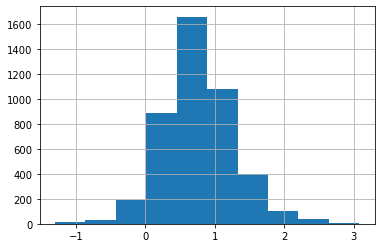

In [46]:
# look at distribution of average temperature column in the training dataset
hist=train['average_temperature_°c'].hist()

In [47]:
# explore quartiles of average temperature column in training set
train_tree['average_temperature_°c'].describe()

count    4409.000000
mean        0.760066
std         0.508665
min        -1.302417
25%         0.441750
50%         0.733167
75%         1.048333
max         3.080333
Name: average_temperature_°c, dtype: float64

**Elected to recast temp to 4 classes roughly based on quartiles**

Validation and Test datasets will be cast with the same distribution as the training set

In [48]:
train_tree.loc[(train_tree['average_temperature_°c']<=0.44), 
                 'average_temperature_°c_cat'] = 0
train_tree.loc[(train_tree['average_temperature_°c']>0.44) & (train_tree['average_temperature_°c']<=0.72), 
                 'average_temperature_°c_cat'] = 1
train_tree.loc[(train_tree['average_temperature_°c']>0.72) & (train_tree['average_temperature_°c']<=1.04), 
                 'average_temperature_°c_cat'] = 2
train_tree.loc[(train_tree['average_temperature_°c']>1.04), 
                 'average_temperature_°c_cat'] = 3

In [49]:
val_tree.loc[(val_tree['average_temperature_°c']<=0.44), 
                 'average_temperature_°c_cat'] = 0
val_tree.loc[(val_tree['average_temperature_°c']>0.44) & (val_tree['average_temperature_°c']<=0.72), 
                 'average_temperature_°c_cat'] = 1
val_tree.loc[(val_tree['average_temperature_°c']>0.72) & (val_tree['average_temperature_°c']<=1.04), 
                 'average_temperature_°c_cat'] = 2
val_tree.loc[(val_tree['average_temperature_°c']>1.04), 
                 'average_temperature_°c_cat'] = 3

In [50]:
test_tree.loc[(test_tree['average_temperature_°c']<=0.44), 
                 'average_temperature_°c_cat'] = 0
test_tree.loc[(test_tree['average_temperature_°c']>0.44) & (test_tree['average_temperature_°c']<=0.72), 
                 'average_temperature_°c_cat'] = 1
test_tree.loc[(test_tree['average_temperature_°c']>0.72) & (test_tree['average_temperature_°c']<=1.04), 
                 'average_temperature_°c_cat'] = 2
test_tree.loc[(test_tree['average_temperature_°c']>1.04), 
                 'average_temperature_°c_cat'] = 3

In [69]:
# make sure the type of these new columns are integers
train_tree['average_temperature_°c_cat']=train_tree['average_temperature_°c_cat'].astype(int)
val_tree['average_temperature_°c_cat']=val_tree['average_temperature_°c_cat'].astype(int)
test_tree['average_temperature_°c_cat']=test_tree['average_temperature_°c_cat'].astype(int)

In [52]:
# checking spread of categories (should be pretty even)
count=pd.DataFrame(train_tree.groupby('average_temperature_°c_cat')['average_temperature_°c_cat'].count())
count

,average_temperature_°c_cat
average_temperature_°c_cat,
0,1095
1,1065
2,1117
3,1132


In [71]:
count['prob']=count['average_temperature_°c_cat']/4409
count

,average_temperature_°c_cat,prob
average_temperature_°c_cat,,
0,1095,0.248356
1,1065,0.241551
2,1117,0.253345
3,1132,0.256748


The above is checking probabilities of each are fairly even

In [74]:
# doing the same thing using get_parent_distribution function defined above
parent_dist=get_parent_distribution(np.array(train_tree['average_temperature_°c_cat']))
dict_parent_dist={i:parent_dist[i] for i in range(4)}
print(dict_parent_dist)

{0: 0.2483556361986845, 1: 0.2415513721932411, 2: 0.2533454298026763, 3: 0.25674756180539804}


In [75]:
entropy(parent_dist)

1.99962150936443

### First Experiment with Feature: total_emissions (baseline)

In [29]:
label=['average_temperature_°c_cat']
features=['total_emission']
df1_train = train_tree[label+features]
df1_val = val_tree[label+features]
df1_test = test_tree[label+features]

Using a decision stump -- a tree with depth 1:
Features: ['total_emission']
Feature importances: [1.]
Accuracy: 0.5716945996275605
Accuracy: 0.5623836126629422


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

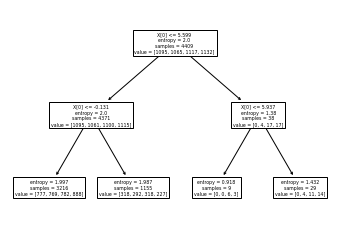

In [30]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(df1_train[features], df1_train[label])
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df1_val[features], df1_val[label]))
print ('Accuracy:', dt.score(df1_test[features], df1_test[label]))

### Second Experiment, adding in regions

In [165]:
label=['average_temperature_°c_cat']
features=['total_emission', 'region_Africa', 'region_Americas',
       'region_Asia', 'region_Europe', 'region_Oceania']
df2_train = train_tree[label+features]
df2_val = val_tree[label+features]
df2_test = test_tree[label+features]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

Using a decision stump -- a tree with depth 1:
Features: ['total_emission', 'region_Africa', 'region_Americas', 'region_Asia', 'region_Europe', 'region_Oceania']
Feature importances: [0.12811305 0.         0.14685051 0.         0.59538552 0.12965093]
Accuracy: 0.260707635009311
Accuracy: 0.29236499068901306


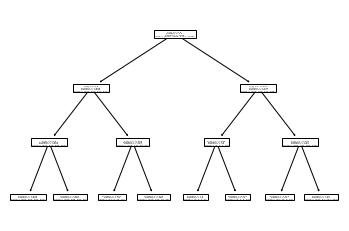

In [168]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dt.fit(df2_train[features], df2_train[label])
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df2_val[features], df2_val[label]))
print ('Accuracy:', dt.score(df2_test[features], df2_test[label]))

### Third Experiment, Adding in some original features

In [199]:
label=['average_temperature_°c_cat']
features=['total_emission', 'region_Africa', 'region_Americas',
       'region_Asia', 'region_Europe', 'region_Oceania', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2',
       'forestland', 'net_forest_conversion', 'fires', 'manure_mgmt',
       'food_systems', 'ippu_tot', 'on_farm_energy_use', 'mei']
df3_train = train_tree[label+features]
df3_val = val_tree[label+features]
df3_test = test_tree[label+features]
df3_train.head()

,average_temperature_°c_cat,total_emission,region_Africa,region_Americas,region_Asia,region_Europe,region_Oceania,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
0,1,-0.305623,0,0,1,0,0,-0.213514,-0.205388,-0.248996,0.214527,-0.184896,-0.166866,-0.248892,-0.252496,-0.206061,0.191216,0.2
1,2,-0.300144,0,0,0,1,0,-0.255139,-0.238919,-0.242540,0.242892,-0.184896,-0.166941,-0.304350,-0.259606,-0.197917,-0.241381,0.2
2,2,-0.219228,1,0,0,0,0,-0.225268,-0.239892,-0.248996,0.240772,-0.179044,-0.162479,-0.219602,-0.113537,-0.159908,-0.252592,0.2
3,1,-0.015169,1,0,0,0,0,-0.262785,-0.238858,-0.228766,0.242053,-0.100769,1.706541,-0.270488,-0.246282,-0.203060,-0.258101,0.2
4,0,0.175566,0,1,0,0,0,0.286965,-0.193833,0.050432,-0.220040,0.511570,-0.018155,0.998713,-0.050755,-0.132390,0.051455,0.2


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

Using a decision stump -- a tree with depth 1:
Features: ['total_emission', 'region_Africa', 'region_Americas', 'region_Asia', 'region_Europe', 'region_Oceania', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'forestland', 'net_forest_conversion', 'fires', 'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'mei']
Feature importances: [0.         0.         0.         0.         0.41192878 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.58807122]
Accuracy: 0.14152700186219738
Accuracy: 0.32774674115456237


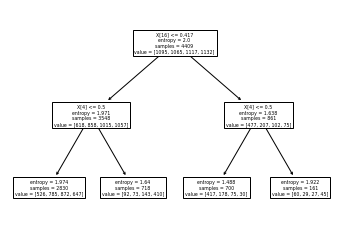

In [201]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(df3_train[features], df3_train[label])
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df3_val[features], df3_val[label]))
print ('Accuracy:', dt.score(df3_test[features], df3_test[label]))

### Fourth experiment, removed regions

In [197]:
label=['average_temperature_°c_cat']
features=['total_emission', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2',
       'forestland', 'net_forest_conversion', 'fires', 'manure_mgmt',
       'food_systems', 'ippu_tot', 'on_farm_energy_use']
df4_train = train_tree[label+features]
df4_val = val_tree[label+features]
df4_test = test_tree[label+features]
df4_train.head()

,average_temperature_°c_cat,total_emission,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use
0,1,-0.305623,-0.213514,-0.205388,-0.248996,0.214527,-0.184896,-0.166866,-0.248892,-0.252496,-0.206061,0.191216
1,2,-0.300144,-0.255139,-0.238919,-0.242540,0.242892,-0.184896,-0.166941,-0.304350,-0.259606,-0.197917,-0.241381
2,2,-0.219228,-0.225268,-0.239892,-0.248996,0.240772,-0.179044,-0.162479,-0.219602,-0.113537,-0.159908,-0.252592
3,1,-0.015169,-0.262785,-0.238858,-0.228766,0.242053,-0.100769,1.706541,-0.270488,-0.246282,-0.203060,-0.258101
4,0,0.175566,0.286965,-0.193833,0.050432,-0.220040,0.511570,-0.018155,0.998713,-0.050755,-0.132390,0.051455


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

Using a decision stump -- a tree with depth 1:
Features: ['total_emission', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'forestland', 'net_forest_conversion', 'fires', 'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use']
Feature importances: [0.12033756 0.         0.18647846 0.         0.04002122 0.21694338
 0.05176681 0.15732882 0.01937968 0.         0.20774408]
Accuracy: 0.5065176908752328
Accuracy: 0.5046554934823091


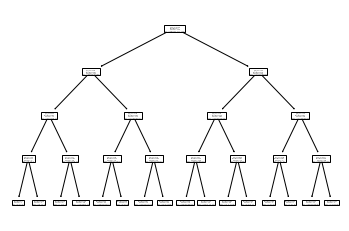

In [198]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt.fit(df4_train[features], df4_train[label])
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df4_val[features], df4_val[label]))
print ('Accuracy:', dt.score(df4_test[features], df4_test[label]))

### Fifth Experiment, used regions and log features

In [188]:
label=['average_temperature_°c_cat']
features=['total_emission', 'region_Africa', 'region_Americas',
       'region_Asia', 'region_Europe', 'region_Oceania', 'log_crop_residues', 'log_rice_cultivation', 
       'log_drained_organic_soils_co2', 'log_net_forest_conversion', 'log_fires', 'log_manure_mgmt', 
       'log_food_systems', 'log_ippu_tot','log_on_farm_energy_use', 'mei']
df5_train = train_tree[label+features]
df5_val = val_tree[label+features]
df5_test = test_tree[label+features]
df5_train.head()

,average_temperature_°c_cat,total_emission,region_Africa,region_Americas,region_Asia,region_Europe,region_Oceania,log_crop_residues,log_rice_cultivation,log_drained_organic_soils_co2,log_net_forest_conversion,log_fires,log_manure_mgmt,log_food_systems,log_ippu_tot,log_on_farm_energy_use,mei
0,1,-0.305623,0,0,1,0,0,0.422144,0.342241,-0.956054,-1.114980,-0.333673,0.297143,-0.605388,-1.707076,1.307739,0.2
1,2,-0.300144,0,0,0,1,0,-0.061720,-1.058319,0.257582,-1.114980,-0.376785,-0.017793,-0.986067,-0.726567,-0.064009,0.2
2,2,-0.219228,1,0,0,0,0,0.334521,-1.701069,-0.956054,0.374969,0.305171,0.402005,0.742244,0.240258,-0.468922,0.2
3,1,-0.015169,1,0,0,0,0,-0.293816,-1.038119,0.550034,0.982801,2.013043,0.199645,-0.402676,-1.159808,-1.104668,0.2
4,0,0.175566,0,1,0,0,0,1.306719,0.462813,1.243005,1.465005,1.285850,1.402426,0.938794,0.522173,1.148839,0.2


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

Using a decision stump -- a tree with depth 1:
Features: ['total_emission', 'region_Africa', 'region_Americas', 'region_Asia', 'region_Europe', 'region_Oceania', 'log_crop_residues', 'log_rice_cultivation', 'log_drained_organic_soils_co2', 'log_net_forest_conversion', 'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot', 'log_on_farm_energy_use', 'mei']
Feature importances: [0.00963196 0.         0.05060164 0.         0.20499212 0.
 0.         0.02913198 0.00638131 0.082687   0.0487719  0.
 0.03419536 0.         0.05509424 0.4785125 ]
Accuracy: 0.23649906890130354
Accuracy: 0.5325884543761639


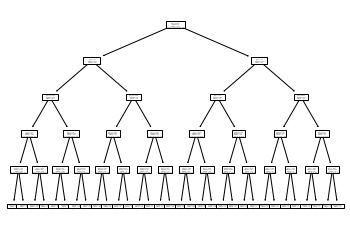

In [195]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dt.fit(df5_train[features], df5_train[label])
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df5_val[features], df5_val[label]))
print ('Accuracy:', dt.score(df5_test[features], df5_test[label]))

### Sixth experiment, used cummulative log features and regions

In [208]:
label=['average_temperature_°c_cat']
features=['region_Africa', 'region_Americas',
       'region_Asia', 'region_Europe', 'region_Oceania', 'cum_sum_log_crop_residues',
       'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2',
       'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
       'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems',
       'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use',
       'cum_sum_forestland', 'cum_sum_total_emission', 'mei']
df6_train = train_tree[label+features]
df6_val = val_tree[label+features]
df6_test = test_tree[label+features]
df6_train.head()

,average_temperature_°c_cat,region_Africa,region_Americas,region_Asia,region_Europe,region_Oceania,cum_sum_log_crop_residues,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission,mei
0,1,0,0,1,0,0,-1.011649,-1.237445,-0.755247,-0.881832,-0.843994,-1.355164,-1.521086,-1.576384,-1.235443,0.227165,-0.289865,0.2
1,2,0,0,0,1,0,-1.037319,-1.299575,-0.680378,-0.881832,-0.846580,-1.367112,-1.531467,-1.551389,-1.293698,0.229297,-0.289443,0.2
2,2,1,0,0,0,0,-1.016298,-1.328088,-0.755247,-0.791029,-0.805673,-1.351186,-1.484337,-1.526743,-1.310894,0.229137,-0.283210,0.2
3,1,1,0,0,0,0,-1.049631,-1.298679,-0.662337,-0.753985,-0.703226,-1.358863,-1.515558,-1.562433,-1.337892,0.229234,-0.267490,0.2
4,0,0,1,0,0,0,-0.964722,-1.232097,-0.619588,-0.724598,-0.746847,-1.313234,-1.478977,-1.519556,-1.242191,0.194503,-0.252797,0.2


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

Using a decision stump -- a tree with depth 1:
Features: ['region_Africa', 'region_Americas', 'region_Asia', 'region_Europe', 'region_Oceania', 'cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2', 'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires', 'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems', 'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use', 'cum_sum_forestland', 'cum_sum_total_emission', 'mei']
Feature importances: [0.         0.         0.         0.22210434 0.         0.04596551
 0.01281267 0.         0.06848314 0.         0.01699879 0.509484
 0.         0.         0.01715665 0.01439846 0.09259645]
Accuracy: 0.4729981378026071
Accuracy: 0.4748603351955307


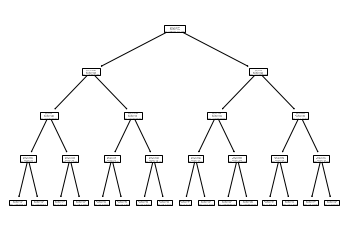

In [211]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt.fit(df6_train[features], df6_train[label])
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df6_val[features], df6_val[label]))
print ('Accuracy:', dt.score(df6_test[features], df6_test[label]))

### Experiment 7, used cummulative log features and no regions

In [54]:
label=['average_temperature_°c_cat']
features=['cum_sum_log_crop_residues',
       'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2',
       'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
       'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems',
       'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use',
       'cum_sum_forestland', 'cum_sum_total_emission', 'mei']
df7_train = train_tree[label+features]
df7_val = val_tree[label+features]
df7_test = test_tree[label+features]
df7_train.head()

,average_temperature_°c_cat,cum_sum_log_crop_residues,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission,mei
0,1,-1.011649,-1.237445,-0.755247,-0.881832,-0.843994,-1.355164,-1.521086,-1.576384,-1.235443,0.227165,-0.289865,0.2
1,2,-1.037319,-1.299575,-0.680378,-0.881832,-0.846580,-1.367112,-1.531467,-1.551389,-1.293698,0.229297,-0.289443,0.2
2,2,-1.016298,-1.328088,-0.755247,-0.791029,-0.805673,-1.351186,-1.484337,-1.526743,-1.310894,0.229137,-0.283210,0.2
3,1,-1.049631,-1.298679,-0.662337,-0.753985,-0.703226,-1.358863,-1.515558,-1.562433,-1.337892,0.229234,-0.267490,0.2
4,0,-0.964722,-1.232097,-0.619588,-0.724598,-0.746847,-1.313234,-1.478977,-1.519556,-1.242191,0.194503,-0.252797,0.2


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

Using a decision stump -- a tree with depth 1:
Features: ['cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2', 'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires', 'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems', 'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use', 'cum_sum_forestland', 'cum_sum_total_emission', 'mei']
Feature importances: [0.04865795 0.02881795 0.         0.03390245 0.1062054  0.01245901
 0.47391298 0.01413334 0.05402712 0.06734626 0.05289292 0.10764462]
Accuracy: 0.40409683426443205
Accuracy: 0.3929236499068901


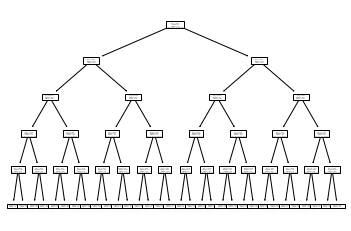

In [33]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dt.fit(df7_train[features], df7_train[label])
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df7_val[features], df7_val[label]))
print ('Accuracy:', dt.score(df7_test[features], df7_test[label]))

## Random Forest Exploration
Finally, I did a Random Forest classifier experiment using the seventh df setup. At this point I felt like a classification approach was not appropriate for this problem. Faye was simulatenously trying regression trees, and we decided to use those in our final presentation.

In [63]:
dt = RandomForestClassifier(criterion='gini')
dt.fit(df7_train[features], df7_train[label])

print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(df7_val[features], df7_val[label]))
print ('Accuracy:', dt.score(df7_test[features], df7_test[label]))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_89051/4280717829.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  dt.fit(df7_train[features], df7_train[label])


Using a decision stump -- a tree with depth 1:
Features: ['cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2', 'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires', 'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems', 'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use', 'cum_sum_forestland', 'cum_sum_total_emission', 'mei']
Feature importances: [0.08787146 0.0909569  0.05148138 0.07067307 0.0865832  0.09027598
 0.10276095 0.09115255 0.09657367 0.07760018 0.08821089 0.06585977]
Accuracy: 0.5344506517690876
Accuracy: 0.5121042830540037


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
